In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import itertools


Populating the interactive namespace from numpy and matplotlib


In [3]:

tb, te = 0., 15.
xb, xe = -2*np.pi, 2*np.pi
vb, ve = -4.5, 4.5

BD = 2 #boundary cells in x-dimension
mx, mvx = 32, 32
sizex = mx + 2*BD
steps = 150 #number of samples in time 

#load data
path = '../Datasets/VlasovLD/'

fe = np.load(path+'f_e.npy')
x = np.load(path+'x.npy')
v = np.load(path+'v.npy')
E = np.load(path+'E.npy')
t = np.load(path+'t.npy')


In [4]:
print(np.shape(E))
print(np.shape(x))
print(np.shape(v))
print(np.shape(t))
print(np.shape(fe))

(150, 36)
(36,)
(32,)
(150,)
(150, 36, 32)


In [5]:
dx = x[1] - x[0]
dv = v[1] - v[0]
dt = t[1] - t[0]
print(dx)
print(dv)
print(dt)

0.3926990816987237
0.29032258064516103
0.10999999999999999


Text(0.5, 0.92, 'Oscillating Electric field')

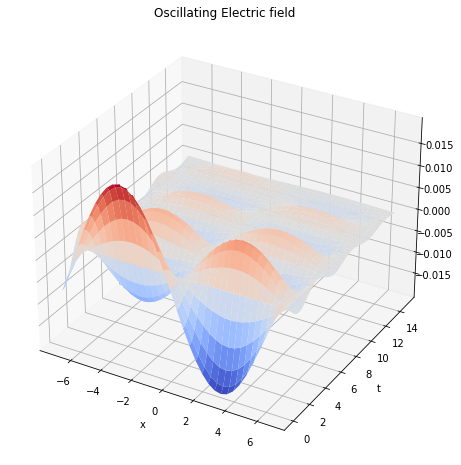

In [6]:
#plot Example
X, T = np.meshgrid(x, t)
fig1 = plt.figure()
ax = fig1.gca(projection = '3d')
surf = ax.plot_surface(X, T, E, cmap=cm.coolwarm)
xlabel('x')
ylabel('t')
title('Oscillating Electric field')

In [7]:
#reshape data
#fen = fe.reshape(sizex, mvx, steps)

In [8]:
#construct theta and compute Ut

#take up to second order derivatives
fe_t  = np.zeros((steps, sizex, mvx))
fe_x  = np.zeros((steps, sizex, mvx))
fe_v  = np.zeros((steps, sizex, mvx))
fe_xx = np.zeros((steps, sizex, mvx))
fe_vv = np.zeros((steps, sizex, mvx))
fe_xv = np.zeros((steps, sizex, mvx))

vn = np.zeros((steps, sizex, mvx))
xn = np.zeros((steps, sizex, mvx))
En = np.zeros((steps, sizex, mvx))

#t-derivative
for i in range(sizex):
    for j in range(mvx):
        fe_t[:,i,j] = FiniteDiff(fe[:,i,j], dt, 1)

#x-derivatives
for s in range(steps):
    for j in range(mvx):
        fe_x[s,:,j] = FiniteDiff(fe[s,:,j], dx, 1)
        fe_xx[s,:,j] = FiniteDiff(fe[s,:,j], dx, 2)
        
        xn[s,:,j] = x[:]
        En[s,:,j] = E[s,:]

#v-derivatives
for s in range(steps):
    for i in range(sizex):
        fe_v[s,i,:] = FiniteDiff(fe[s,i,:], dv, 1)
        fe_vv[s,i,:] = FiniteDiff(fe[s,i,:], dv, 2)
        
        vn[s,i,:] = v[:]
        
#mixed derivative
for s in range(steps):
    for i in range(sizex):
        fe_xv[s,i,:] = FiniteDiff(fe_x[s,i,:], dv, 1)
        

/home/lukas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/home/lukas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/home/lukas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/home/lukas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
/home/lukas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
/home/lukas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [9]:
#flatten the data
num_xv = sizex*mvx
num_t = steps
num_points = num_xv * num_t
print(num_points)

fen = fe.reshape((num_points, 1))
vn = vn.reshape((num_points, 1))
xn = xn.reshape((num_points, 1))
En = En.reshape((num_points, 1))

print('fen shape:', np.shape(fen))
print('xn shape:', np.shape(xn))
print('vn shape:', np.shape(vn))
print('En shape:', np.shape(En))


fe_t = fe_t.reshape((num_points, 1))
fe_x = fe_x.reshape((num_points, 1))
fe_v = fe_v.reshape((num_points, 1))
fe_xx = fe_xx.reshape((num_points, 1))
fe_xv = fe_xv.reshape((num_points, 1))
fe_vv = fe_vv.reshape((num_points, 1))

print('fe_t shape:', np.shape(fe_t))
print('fe_x shape:', np.shape(fe_x))
print('fe_v shape:', np.shape(fe_v))
print('fe_xx shape:', np.shape(fe_xx))
print('fe_vv shape:', np.shape(fe_vv))
print('fe_xv shape:', np.shape(fe_xv))

172800
fen shape: (172800, 1)
xn shape: (172800, 1)
vn shape: (172800, 1)
En shape: (172800, 1)
fe_t shape: (172800, 1)
fe_x shape: (172800, 1)
fe_v shape: (172800, 1)
fe_xx shape: (172800, 1)
fe_vv shape: (172800, 1)
fe_xv shape: (172800, 1)


In [10]:
#form theta
X_data = np.hstack([fen, xn, vn, En])
X_ders = np.hstack([np.ones((num_points,1)), fe_x, fe_v, fe_xx, fe_xv, fe_vv])
X_ders_descr = ['', 'fe_{x}', 'fe_{v}', 'fe_{xx}', 'fe_{xv}', 'fe_{vv}']

In [11]:
#build theta library
Theta, description = build_Theta(X_data, X_ders, X_ders_descr, 1, data_description=['fe', 'x', 'v', 'E'])

print('Candidate terms for PDE')
print(['1'] + description[1:])

Candidate terms for PDE
['1', 'fe_{x}', 'fe_{v}', 'fe_{xx}', 'fe_{xv}', 'fe_{vv}', 'E', 'v', 'x', 'fe', 'Efe_{x}', 'vfe_{x}', 'xfe_{x}', 'fefe_{x}', 'Efe_{v}', 'vfe_{v}', 'xfe_{v}', 'fefe_{v}', 'Efe_{xx}', 'vfe_{xx}', 'xfe_{xx}', 'fefe_{xx}', 'Efe_{xv}', 'vfe_{xv}', 'xfe_{xv}', 'fefe_{xv}', 'Efe_{vv}', 'vfe_{vv}', 'xfe_{vv}', 'fefe_{vv}']


In [12]:
#solve for xi / find sparse solution

#TrainSTRidge
lam = 10**-5
d_tol = 5.
c1 = TrainSTRidge(Theta, fe_t, lam, d_tol, maxit = 25, print_best_tol = True)

#print resulting pde
print('Result from TrainSTRidge')
print_pde(c1, description, ut = 'fe_t')

Optimal tolerance: 0.3348717948717948
Result from TrainSTRidge
fe_t = (-0.945390 +0.000000i)vfe_{x}
   


In [13]:
#Lasso
c2 = Lasso(Theta, fe_t, lam=1.)

print('Result from Lasso')
print_pde(c2, description, ut = 'fe_t')

/home/lukas/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Result from Lasso
fe_t = 


In [16]:
#STRidge
c3 = STRidge(Theta, fe_t, lam = lam, maxit = 30, tol = 0.1)

print('Result from STRidge')
print_pde(c3, description, ut = 'fe_t')

Result from STRidge
fe_t = (-0.870356 +0.000000i)vfe_{x}
    + (0.973072 +0.000000i)Efe_{v}
   
